In [39]:
import torch
import torch.nn.functional as F
from torch import nn, einsum
from einops import rearrange, reduce
from einops.layers.torch import Rearrange
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import imageio
import math
from inspect import isfunction
from functools import partial
from PIL import Image

import torch
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm.auto import tqdm

Here is the process of how noise an image work. We will use this image below as the example.

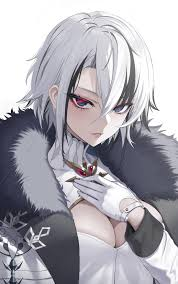

In [44]:
from IPython.display import Image

Image('arle.jpeg')

In [40]:
timesteps = 300

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod) # A.K.A betas sqrt

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [41]:
#extract schedule parameter
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    #print('cek shape comparison', x_start.size(), t.size())
    #print(len(sqrt_alphas_cumprod))
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    #print('cek shpae extract', sqrt_alphas_cumprod_t.size())
    #print(sqrt_alphas_cumprod_t)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )
    
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [42]:
from PIL import Image

batch_size = 1
noise_episode = [0, 50, 100, 150, 200, 250, 299]

#x_start = torch.rand((batch_size, 3, 64, 64))
img = Image.open('arle.jpeg').convert("RGB")
img = np.array(img).astype(float)
img_container = np.zeros((len(noise_episode), len(img), len(img[0]), len(img[0,0])))
img_container[:] = img
x_start = torch.from_numpy(img_container)
x_start = x_start / 255
x_start.size()

#t = torch.randint(0, timesteps, (batch_size,)).long()
t = torch.tensor(noise_episode)
noise = torch.randn_like(x_start)
x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
x_noisy.size()
x_noisy = torch.permute(x_noisy, (0, 3, 1, 2))

Save the array as image

In [43]:
from torchvision.utils import save_image

for i in range(x_noisy.size(0)):
    save_image(x_noisy[i], 'img_noise-%s.png'%(i))

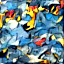

In [3]:
from IPython.display import Image

Image('res128.png')